In [29]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.utils import to_categorical
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout, \
    concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt
import random

### Enable memory growth in GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Constants

In [3]:
WIDTH = 128
HEIGHT = 128
NUM_CLASSES = 8
beach_litter_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter'
images_path = beach_litter_path + '/images' # These are jpgs
masks_path = beach_litter_path + '/maskpngs' # These are pngs

### Convert image and mask data into numpy arrays

In [4]:
def data_to_numpy_arr():
    # Iterate over every file in the directory, resize, append to array
    images_arr = []
    mask_arr = []
    
    image_files = glob.glob(images_path + '/*')
    mask_files = glob.glob(masks_path + '/*')
    
    # black and white for now    
    [images_arr.append(normalize(cv2.resize(cv2.imread(image_file, 0), (HEIGHT, WIDTH)), axis=1)) for image_file in image_files]
    [mask_arr.append(normalize(cv2.resize(cv2.imread(mask_file, 0), (HEIGHT, WIDTH)), axis=1)) for mask_file in mask_files]

    return np.array(images_arr), np.array(mask_arr)

In [5]:
images_arr, mask_arr = data_to_numpy_arr()

In [6]:
print(f'Images array shape {images_arr.shape}')
print(f'Mask array shape {mask_arr.shape}')
print()
print(f'Images array type {images_arr.dtype}')
print(f'Mask array type {mask_arr.dtype}')

Images array shape (3500, 128, 128)
Mask array shape (3500, 128, 128)

Images array type float64
Mask array type float64


In [7]:
np.unique(mask_arr).shape

(1293247,)

### Visualization after processing

In [18]:
def visualize_random_image_pair():
    random_index = np.random.randint(0, len(images_arr))
    random_image = images_arr[random_index]
    random_mask = mask_arr[random_index]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 8])

    fig.suptitle(f'Random image and mask pair for image number {random_index + 1}')
    ax1.imshow(random_image)
    ax2.imshow(random_mask)
    
    plt.show()

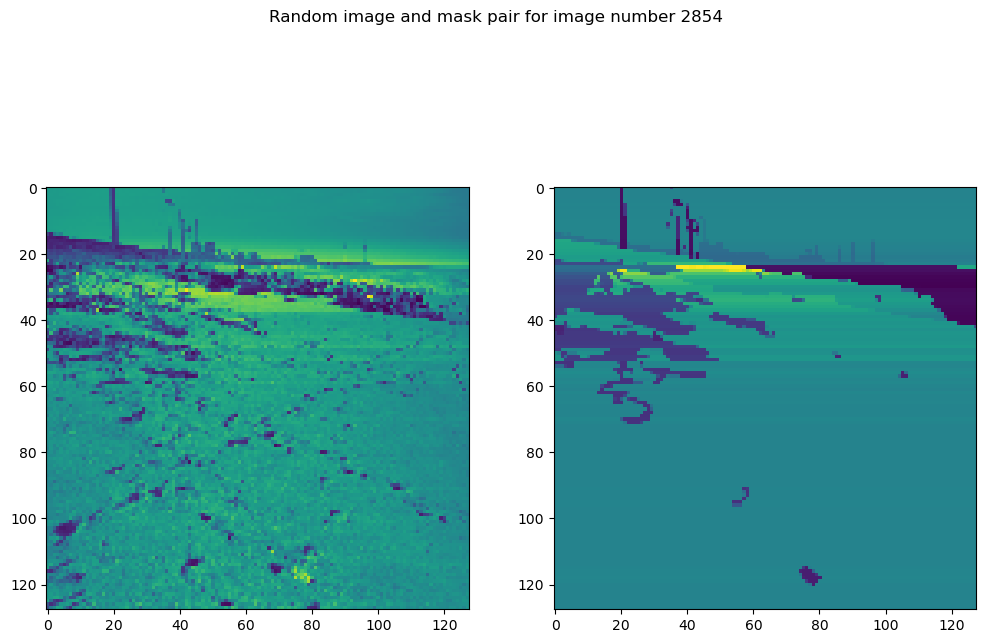

In [21]:
visualize_random_image_pair()

### Reshape so data compatible with neural network

In [10]:
# expand dimensions
images_arr = np.expand_dims(images_arr, axis=3)
mask_arr = np.expand_dims(mask_arr, axis=3)

print(f'Resized images array shape {images_arr.shape}')
print(f'Resized mask array shape {mask_arr.shape}')

Resized images array shape (3500, 128, 128, 1)
Resized mask array shape (3500, 128, 128, 1)


### Train test split

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(images_arr, mask_arr, train_size=0.6, random_state=1)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1) 

In [23]:
print(f'X_train {X_train.shape} \t y_train {y_train.shape}')
print(f'X_val {X_val.shape} \t y_val {y_val.shape}')
print(f'X_test {X_test.shape} \t y_test {y_test.shape}')

X_train (2100, 128, 128, 1) 	 y_train (2100, 128, 128, 1)
X_val (700, 128, 128, 1) 	 y_val (700, 128, 128, 1)
X_test (700, 128, 128, 1) 	 y_test (700, 128, 128, 1)


In [24]:
# add correct number of classes to the input array
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
print(f'y_train_cat {y_train_cat.shape}')
print(f'y_val_cat {y_val_cat.shape}')
print(f'y_test_cat {y_test_cat.shape}')

y_train_cat (2100, 128, 128, 8)
y_val_cat (700, 128, 128, 8)
y_test_cat (700, 128, 128, 8)


### Get model ready

In [25]:
def unet_model(n_classes=8, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [33]:
model = unet_model(8, 128, 128, 1)

model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 128, 128, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

### Hyperparameters

In [36]:
# when training size was .80
# BATCH_SIZE = 2
# EPOCHS = 3

# training size of .6
BATCH_SIZE = 16
EPOCHS = 20

In [37]:
history = model.fit(X_train, y_train_cat, batch_size=BATCH_SIZE, verbose=1, epochs=EPOCHS, validation_data=(X_test, y_test_cat)) 

Epoch 1/20
132/132 [==============================] - 4s 28ms/step - loss: 2.0225 - accuracy: 0.0496 - val_loss: 2.0234 - val_accuracy: 0.0437
Epoch 2/20
132/132 [==============================] - 4s 27ms/step - loss: 1.9765 - accuracy: 0.0789 - val_loss: 1.9784 - val_accuracy: 0.1320
Epoch 3/20
132/132 [==============================] - 4s 27ms/step - loss: 1.9149 - accuracy: 0.1168 - val_loss: 1.9206 - val_accuracy: 0.2327
Epoch 4/20
132/132 [==============================] - 4s 27ms/step - loss: 1.8383 - accuracy: 0.1645 - val_loss: 1.8542 - val_accuracy: 0.2838
Epoch 5/20
132/132 [==============================] - 4s 27ms/step - loss: 1.7569 - accuracy: 0.2171 - val_loss: 1.7879 - val_accuracy: 0.3823
Epoch 6/20
132/132 [==============================] - 4s 27ms/step - loss: 1.6757 - accuracy: 0.2688 - val_loss: 1.7194 - val_accuracy: 0.4426
Epoch 7/20
132/132 [==============================] - 4s 27ms/step - loss: 1.5923 - accuracy: 0.3169 - val_loss: 1.6456 - val_accuracy: 0.4711